Useful Resource: https://www.kaggle.com/competitions/playground-series-s5e6/discussion/587393

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c cmi-detect-behavior-with-sensor-data
!unzip /content/cmi-detect-behavior-with-sensor-data.zip
!rm /content/cmi-detect-behavior-with-sensor-data.zip

Mounted at /content/drive
 66% 118M/178M [00:00<00:00, 1.23GB/s]
100% 178M/178M [00:00<00:00, 986MB/s] 


In [3]:
%%capture
!pip install optuna

## Import Packages

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from sklearn.feature_selection import f_classif

## Load Data

In [5]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
# sub = pd.read_csv('/content/sample_submission.csv')
train_demographics = pd.read_csv('/content/train_demographics.csv')
test_demographics = pd.read_csv('/content/test_demographics.csv')

In [7]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [9]:
train.shape, test.shape

((574945, 340), (107, 335))

In [16]:
display(train.head(2))
test.head(2)

,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
row_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,6.214844,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,6.214844,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


,sequence_id,sequence_counter,subject,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
row_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000001_000000,SEQ_000001,0,SUBJ_055840,9.039062,5.261719,0.800781,0.367188,-0.397400,-0.629028,-0.558167,...,97.0,87.0,206.0,-1.0,195.0,-1.0,-1.0,-1.0,111.0,-1.0
SEQ_000001_000001,SEQ_000001,1,SUBJ_055840,9.421875,3.460938,-1.113281,0.353882,-0.507141,-0.652710,-0.437683,...,175.0,158.0,-1.0,-1.0,-1.0,-1.0,-1.0,211.0,187.0,178.0


## EDA

### Missing Values Check

In [17]:
target = 'gesture' #list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]

In [14]:
# Initialize a list to store data
data = []

for column in test.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column != target:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len(unique_train_values - unique_test_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    else:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,sequence_id,object,0.0,0.0,0.0142,8151,2,100.00
1,sequence_counter,int64,0.0,0.0,0.0012,700,56,92.00
2,subject,object,0.0,0.0,0.0001,81,2,100.00
3,acc_x,float64,0.0,0.0,0.0143,8225,78,99.05
4,acc_y,float64,0.0,0.0,0.0113,6497,69,98.94
...,...,...,...,...,...,...,...,...
330,tof_5_v59,float64,5.2,0.0,0.0004,251,5,98.01
331,tof_5_v60,float64,5.2,0.0,0.0004,251,18,92.83
332,tof_5_v61,float64,5.2,0.0,0.0004,251,25,90.04
333,tof_5_v62,float64,5.2,0.0,0.0004,251,33,86.85


### Plots

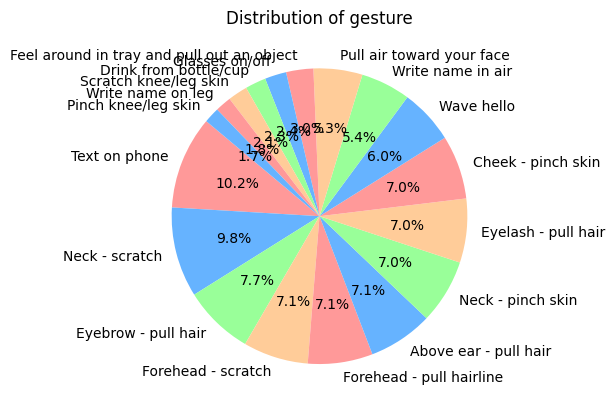

In [20]:
# Pie chart for categorical target
class_counts = train[target].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title(f"Distribution of {target}")

plt.show()

In [21]:
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

#### Numeric

In [24]:
for col in numeric_cols:
    plt.figure(figsize=(8, 5))

    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20 if range_val > 0 else 1
    num_bins = round(range_val / bin_size) if bin_size > 0 else 10

    # Plot the histograms
    plt.hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    plt.hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    plt.title(f'Histogram for {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
classes = train[target].unique()

for col in numeric_cols:
  plt.figure(figsize=(10, 6))

  # Gather data grouped by target
  data_to_plot = [train[train[target] == tgt][col].values for tgt in classes]

  # Create boxplot and get the dictionary of plot elements
  box = plt.boxplot(data_to_plot, tick_labels=classes)

  # Annotate the median values
  for i, median_line in enumerate(box['medians']):
      x, y = median_line.get_xdata(), median_line.get_ydata()
      median_value = y[0]  # both y[0] and y[1] are the same for a horizontal line
      plt.text(x[0], median_value, f'{median_value:.2f}',
              ha='center', va='bottom', fontsize=9, color='blue')

  plt.title(f'Boxplot of {col} by {target}')
  plt.xlabel(target)
  plt.ylabel(col)
  plt.xticks(rotation=45)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

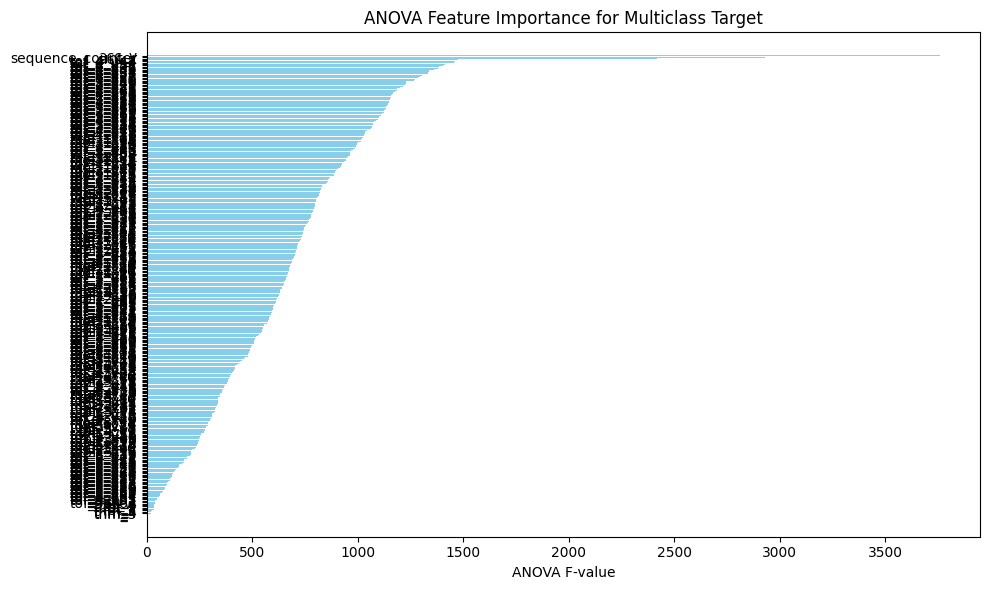

In [31]:
X = train[numeric_cols].fillna(-999)
y = train[target]

# Compute ANOVA F-value
f_vals, p_vals = f_classif(X, y)

# Create DataFrame
anova_df = pd.DataFrame({
    'Feature': X.columns.tolist(),
    'F_value': f_vals,
    'p_value': p_vals
}).sort_values('F_value', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(anova_df['Feature'], anova_df['F_value'], color='skyblue')
plt.xlabel('ANOVA F-value')
plt.title('ANOVA Feature Importance for Multiclass Target')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [33]:
anova_df

,Feature,F_value,p_value
2,acc_y,3761.984452,0.000000e+00
0,sequence_counter,2931.705113,0.000000e+00
1,acc_x,2419.592368,0.000000e+00
248,tof_4_v43,1475.972207,0.000000e+00
249,tof_4_v44,1460.486007,0.000000e+00
...,...,...,...
6,rot_y,36.602984,3.235547e-121
5,rot_x,35.458242,4.248450e-117
10,thm_3,25.385218,4.968667e-81
11,thm_4,19.686824,7.850144e-61


#### Categorical

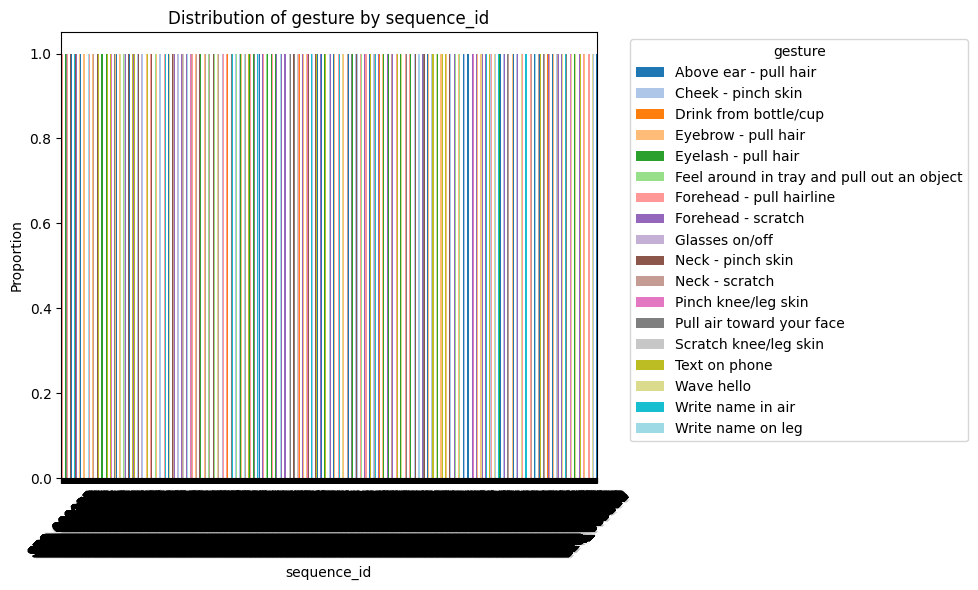

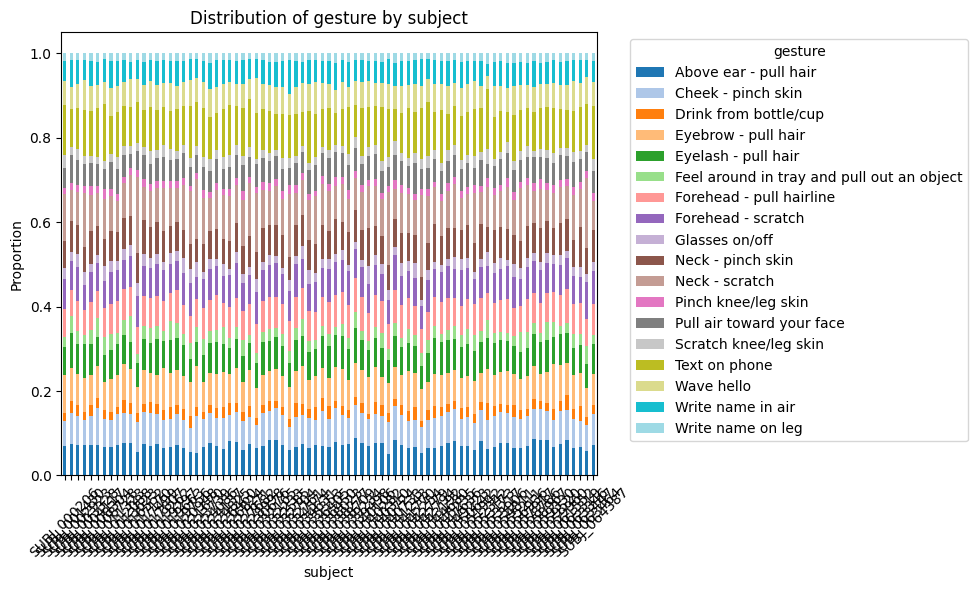

In [34]:
for col in categorical_cols:
  crosstab = pd.crosstab(train[col], train[target], normalize='index')  # row-wise percent
  crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
  plt.title(f'Distribution of {target} by {col}')
  plt.ylabel('Proportion')
  plt.xlabel(col)
  plt.xticks(rotation=45)
  plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.show()

In [35]:
chi2_results = {}

# Encode the multiclass target
y_encoded = LabelEncoder().fit_transform(train[target])

for col in categorical_cols:
    # Encode the categorical feature
    x_encoded = LabelEncoder().fit_transform(train[col]).reshape(-1, 1)

    # Run chi-squared test
    stat, p = chi2(x_encoded, y_encoded)
    chi2_results[col] = {"Chi2 Statistic": stat[0], "p-value": p[0]}

# Convert to DataFrame
chi2_df = pd.DataFrame.from_dict(chi2_results, orient="index")
display(chi2_df.sort_values(by="Chi2 Statistic", ascending=False))

,Chi2 Statistic,p-value
sequence_id,2.240039e+06,0.0
subject,2.023510e+03,0.0


### Unique

## Save to Github

In [36]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [42]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "CMI-Detect-Behaviour"
username = "abishpius"
message = "Kaggle Competition CMI-Detect-Behaviour"
notebook_name = "Kaggle_CMI_Detect_Behaviour_with_Sensor_Data.ipynb"

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"

        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'CMI-Detect-Behaviour' already exists at: https://github.com/abishpius/CMI-Detect-Behaviour


In [38]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.move(f"/content/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add YourNotebook.ipynb
!git commit -m "Add initial notebook"
!git push

NameError: name 'repo_name' is not defined